<a href="https://colab.research.google.com/github/Iftitahyr/Klasifikasi-Penyakit-Daun-Kopi-Menggunakan-Metode-Machine-Learning-Klasik-dan-CNN/blob/main/MLdeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML DEEP LEARNING**

#**load dataset**

Semua library yang dibutuhkan telah diimport.
Mounted at /content/drive
Main Dataset Folder found at: /content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split
Train Set found at: /content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split/train
Validation Set found at: /content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split/val
Test Set found at: /content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split/test

Memuat data training...
Found 3600 images belonging to 3 classes.
Memuat data validasi...
Found 450 images belonging to 3 classes.
Memuat data test...
Found 450 images belonging to 3 classes.

--- Ringkasan Dataset ---
Ditemukan 3 kelas: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']
Jumlah gambar training: 3600
Jumlah gambar validation: 450
Jumlah gambar test: 450

Class Indices Mapping (Indeks -> Nama Kelas):
{'Daun_Bercak': 0, 'Daun_Karat': 1, 'Daun_Sehat': 2}

--- Visualisasi Data ---


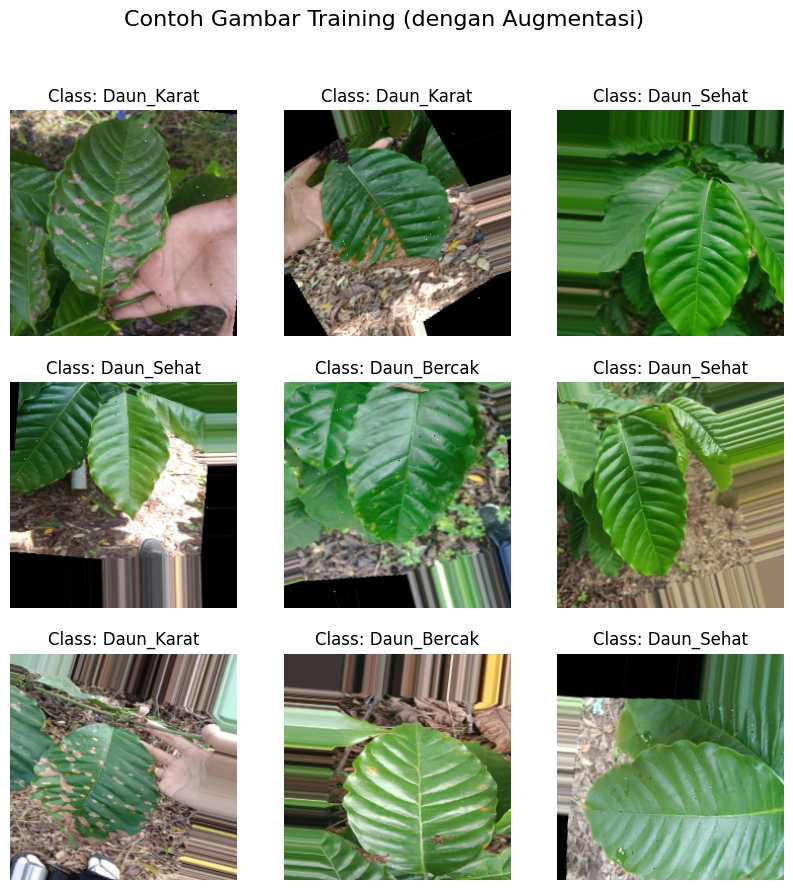

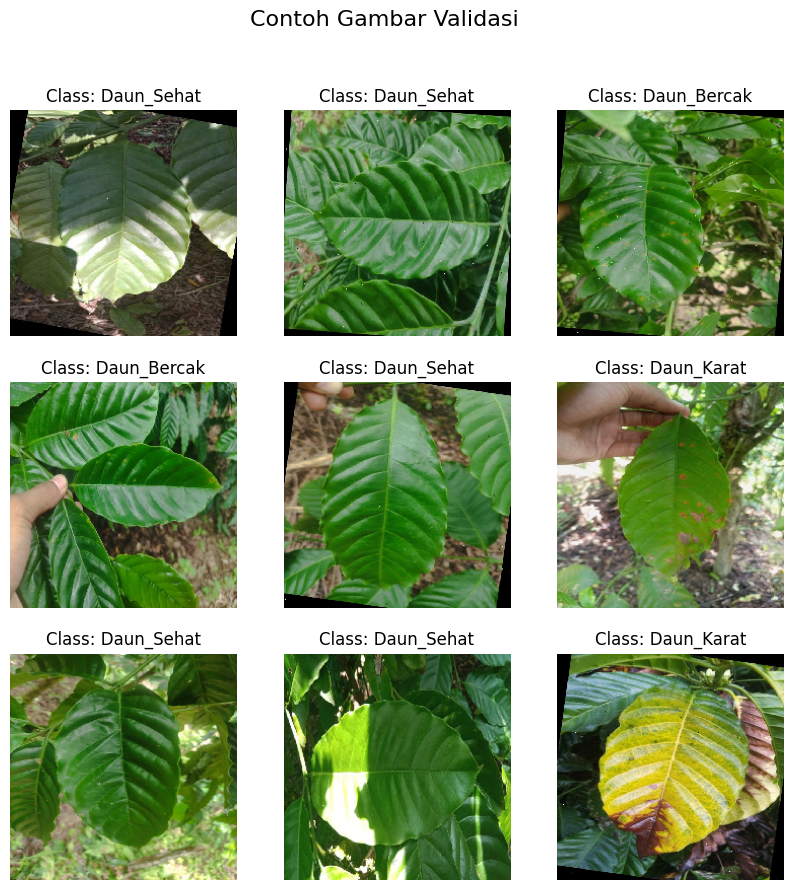

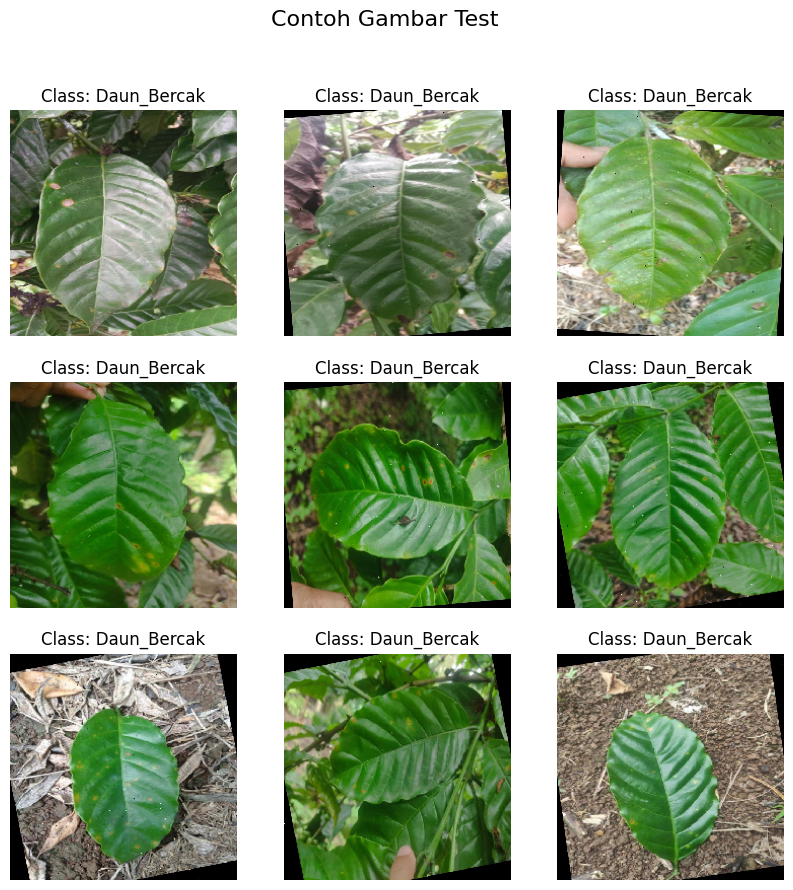


Dataset berhasil dimuat dan diproses dari Google Drive! Kamu sekarang memiliki 'train_generator', 'validation_generator', dan 'test_generator' yang siap digunakan untuk membangun dan melatih model CNN.


In [ ]:
# Import library untuk Deep Learning (TensorFlow dan Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # <<< Tambahkan ini
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import library untuk manipulasi numerik dan array
import numpy as np

# Import library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns # Opsional, untuk plot yang lebih indah

# Import library untuk manipulasi gambar (PIL/Pillow)
from PIL import Image

# Import library untuk utility sistem operasi (misalnya, membaca folder)
import os

# Import library dari Scikit-learn untuk preprocessing dan evaluasi model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.model_selection import train_test_split # Tidak diperlukan jika sudah dibagi train/val/test
# from sklearn.preprocessing import LabelEncoder # Tidak diperlukan jika pakai flow_from_directory dengan categorical

# Import Google Colab utilities
from google.colab import drive, files

print("Semua library yang dibutuhkan telah diimport.")

# Mount Google Drive
drive.mount('/content/drive')

# --- Path Dataset ---
# Path ke folder induk yang berisi 'train', 'val', 'test'
DATASET_PATH = '/content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split'

# Path spesifik untuk setiap set
train_dir = os.path.join(DATASET_PATH, 'train')
val_dir = os.path.join(DATASET_PATH, 'val')
test_dir = os.path.join(DATASET_PATH, 'test')

# Memastikan semua path dataset ada
dirs_to_check = {
    'Main Dataset Folder': DATASET_PATH, # Opsi: Bisa juga cek folder induknya saja
    'Train Set': train_dir,
    'Validation Set': val_dir,
    'Test Set': test_dir
}

for name, path in dirs_to_check.items():
    if not os.path.exists(path):
        print(f"\nERROR: {name} path not found at {path}")
        print("Please check your Google Drive path and make sure the folders are there.")
        # Opsi debug: tampilkan isi folder parent
        parent_path = os.path.dirname(path)
        if os.path.exists(parent_path):
            print(f"\nMencoba menampilkan isi dari '{parent_path}' untuk debugging:")
            !ls "{parent_path}"
        exit() # Hentikan eksekusi jika ada folder yang tidak ditemukan
    else:
        print(f"{name} found at: {path}")

# --- Global Parameters ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42 # Untuk reproduktibilitas


# --- Inisialisasi ImageDataGenerator ---

# Untuk data training: lakukan augmentasi dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalisasi piksel
    rotation_range=20,              # Rotasi gambar acak hingga 20 derajat
    width_shift_range=0.2,          # Geser horizontal hingga 20% lebar gambar
    height_shift_range=0.2,         # Geser vertikal hingga 20% tinggi gambar
    shear_range=0.2,                # Transformasi shear
    zoom_range=0.2,                 # Zoom acak
    horizontal_flip=True,           # Membalik gambar secara horizontal
    fill_mode='nearest',            # Cara mengisi piksel baru setelah augmentasi
)

# Untuk data validasi dan test: hanya normalisasi (tanpa augmentasi)
# Kita ingin menguji model pada data yang tidak diubah
val_test_datagen = ImageDataGenerator(rescale=1./255)


# --- Memuat Data Menggunakan flow_from_directory ---

# Generator untuk data training
print("\nMemuat data training...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Gunakan 'categorical' untuk klasifikasi multi-kelas (one-hot encoding)
    seed=RANDOM_SEED
)

# Generator untuk data validasi
print("Memuat data validasi...")
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Harus sama dengan class_mode di train_generator
    seed=RANDOM_SEED
)

# Generator untuk data test
print("Memuat data test...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # PENTING: Jangan di-shuffle untuk test set agar urutan prediksi konsisten dengan label sebenarnya
)


# --- Ringkasan Dataset yang Telah Dimuat ---
print("\n--- Ringkasan Dataset ---")
class_names = list(train_generator.class_indices.keys())
print(f"Ditemukan {train_generator.num_classes} kelas: {class_names}")
print(f"Jumlah gambar training: {train_generator.samples}")
print(f"Jumlah gambar validation: {validation_generator.samples}")
print(f"Jumlah gambar test: {test_generator.samples}")

# Mapping indeks kelas ke nama kelas
print("\nClass Indices Mapping (Indeks -> Nama Kelas):")
print(train_generator.class_indices)

# --- Visualisasi Beberapa Gambar (Opsional) ---
# Fungsi untuk menampilkan beberapa gambar dari generator
def plot_sample_images(generator, title, class_names_list):
    # Untuk test generator, next() mungkin kosong jika batch_size lebih besar dari jumlah sampel
    # Gunakan try-except untuk penanganan yang lebih baik
    try:
        images, labels = next(generator) # Mengambil satu batch gambar dan label
    except StopIteration:
        print(f"Tidak ada batch tersisa untuk {title}. Melewatkan visualisasi.")
        return

    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)
    for i in range(min(9, len(images))): # Menampilkan hingga 9 gambar
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        # Mengubah label one-hot kembali ke nama kelas
        label_index = np.argmax(labels[i])
        plt.title(f"Class: {class_names_list[label_index]}")
        plt.axis("off")
    plt.show()

print("\n--- Visualisasi Data ---")
plot_sample_images(train_generator, "Contoh Gambar Training (dengan Augmentasi)", class_names)
plot_sample_images(validation_generator, "Contoh Gambar Validasi", class_names)
# Untuk test_generator, pastikan untuk meresetnya jika ingin mengulang iterasi
# atau memanggilnya sekali untuk visualisasi
test_generator.reset() # Reset generator sebelum mengambil batch pertama untuk visualisasi
plot_sample_images(test_generator, "Contoh Gambar Test", class_names)


print("\nDataset berhasil dimuat dan diproses dari Google Drive! Kamu sekarang memiliki 'train_generator', 'validation_generator', dan 'test_generator' yang siap digunakan untuk membangun dan melatih model CNN.")

#**EDA**

--- Memulai EDA (Exploratory Data Analysis) ---

Jumlah kelas yang terdeteksi: 3
Nama-nama kelas: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']
Mapping Indeks Kelas: {'Daun_Bercak': 0, 'Daun_Karat': 1, 'Daun_Sehat': 2}

--- Analisis Distribusi Kelas ---
Distribusi kelas di Training Set (3600 gambar): {'Daun_Bercak': np.int64(1200), 'Daun_Karat': np.int64(1200), 'Daun_Sehat': np.int64(1200)}
Distribusi kelas di Validation Set (450 gambar): {'Daun_Bercak': np.int64(150), 'Daun_Karat': np.int64(150), 'Daun_Sehat': np.int64(150)}
Distribusi kelas di Test Set (450 gambar): {'Daun_Bercak': np.int64(150), 'Daun_Karat': np.int64(150), 'Daun_Sehat': np.int64(150)}


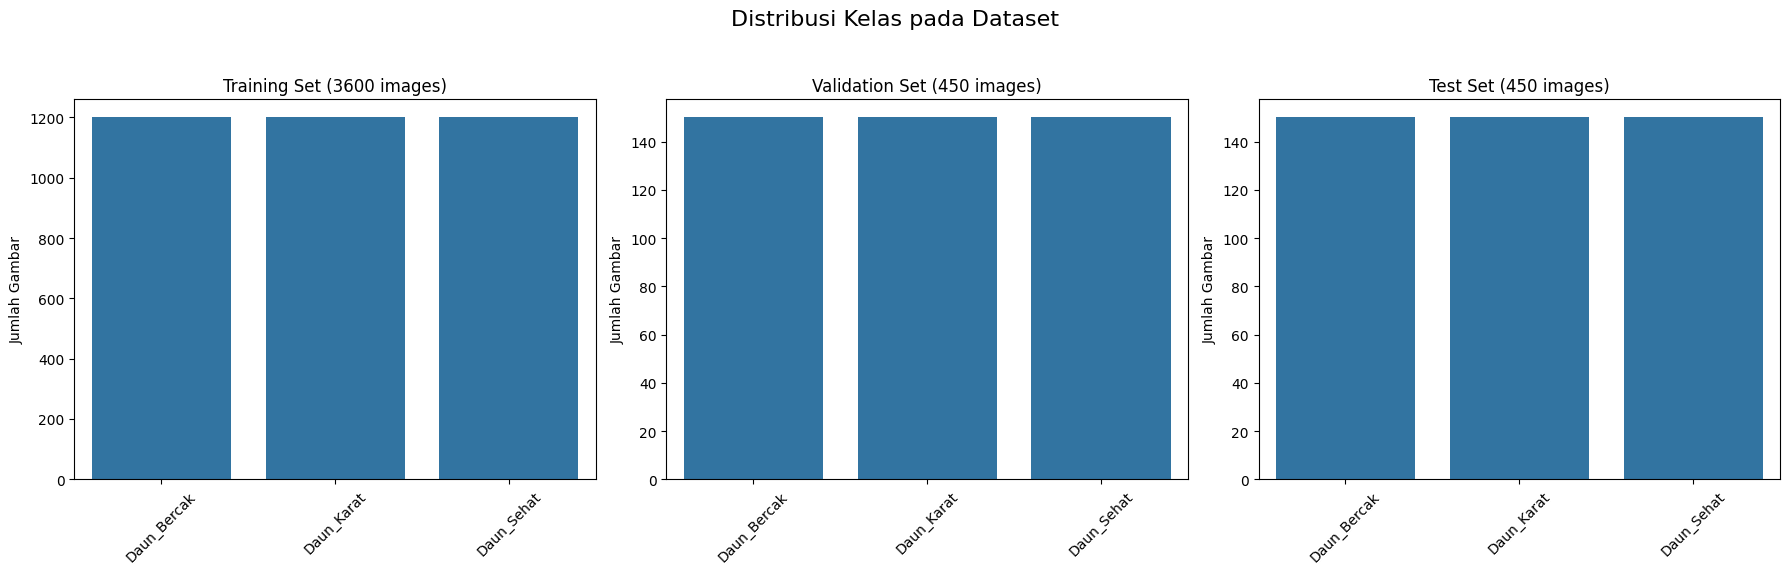


--- Contoh Gambar dari Setiap Kelas (Training Set) ---


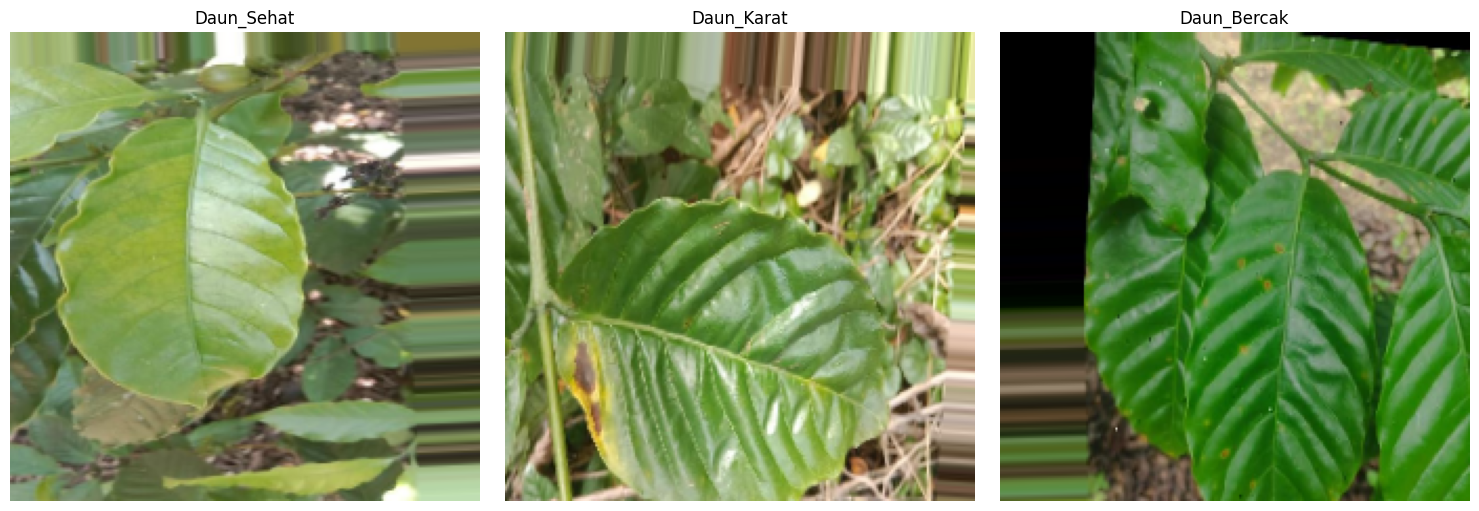


--- Visualisasi Augmentasi Data (Training Set) ---


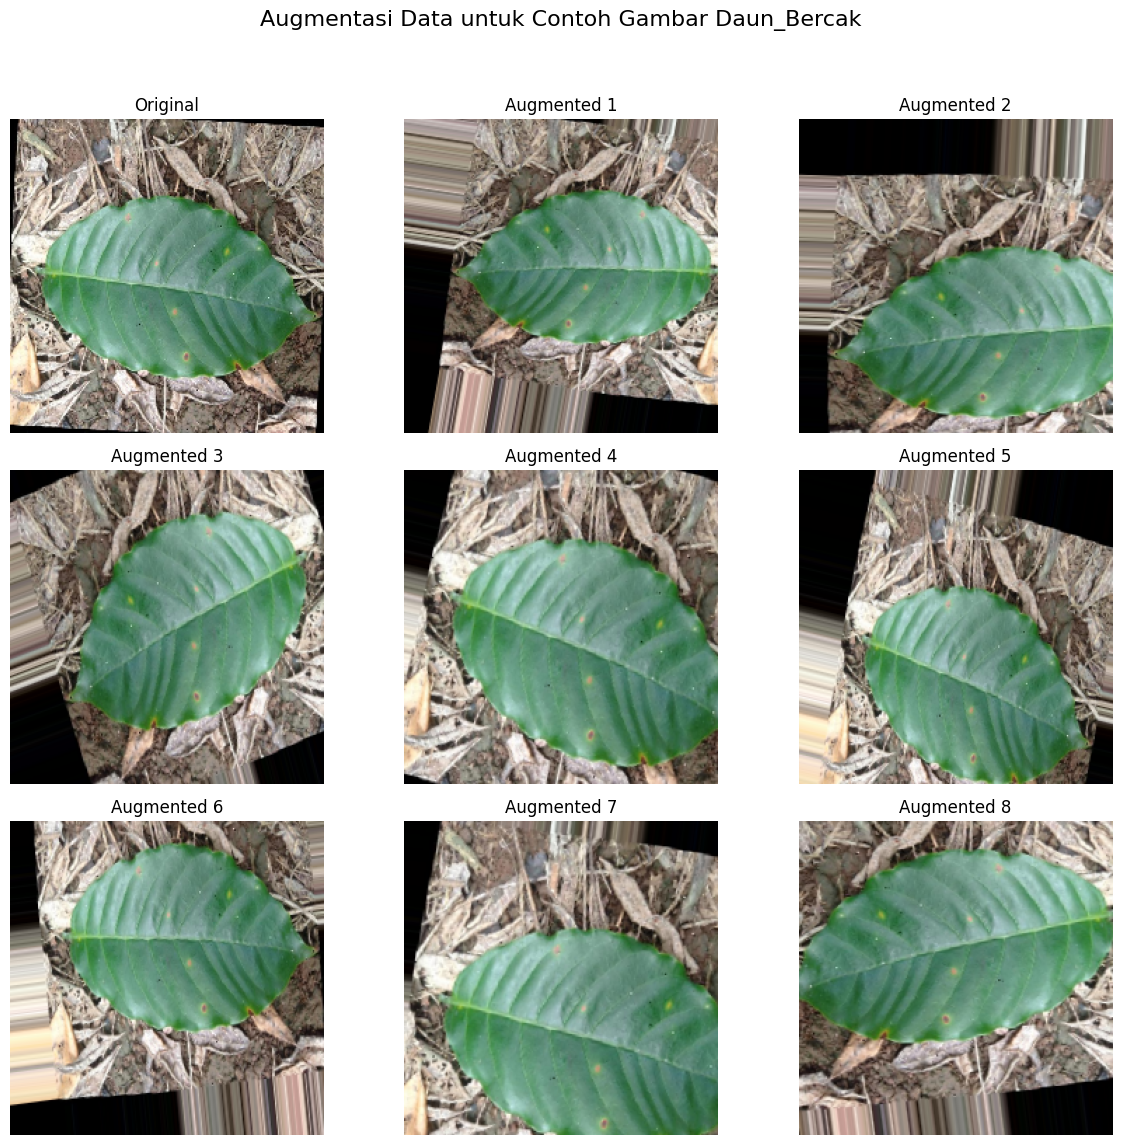


--- EDA Selesai ---


In [ ]:
# --- Ini adalah kode untuk CELL BERIKUTNYA (setelah data loading sukses) ---

print("--- Memulai EDA (Exploratory Data Analysis) ---")

# Dapatkan nama-nama kelas dari generator
class_names = list(train_generator.class_indices.keys())
num_classes = train_generator.num_classes

print(f"\nJumlah kelas yang terdeteksi: {num_classes}")
print(f"Nama-nama kelas: {class_names}")
print(f"Mapping Indeks Kelas: {train_generator.class_indices}")


# --- 1. Distribusi Kelas (Jumlah Gambar per Kelas di Setiap Set) ---
print("\n--- Analisis Distribusi Kelas ---")

def get_class_distribution(generator):
    """Mendapatkan jumlah gambar per kelas dari generator."""
    # Reset generator untuk memastikan iterasi dari awal
    generator.reset()

    # ImageDataGenerator.labels mengandung label integer untuk semua sampel
    # Ini bekerja karena kita menggunakan flow_from_directory dengan shuffle=True untuk train/val dan shuffle=False untuk test.
    # Namun, untuk akurasi penuh dan menghindari masalah shuffle, lebih baik gunakan .labels
    # yang tersedia setelah flow_from_directory dipanggil.

    labels = generator.labels
    class_counts = np.bincount(labels)
    distribution = {class_names[i]: count for i, count in enumerate(class_counts)}
    return distribution, len(labels)

train_dist, train_total = get_class_distribution(train_generator)
val_dist, val_total = get_class_distribution(validation_generator)
test_dist, test_total = get_class_distribution(test_generator)

print(f"Distribusi kelas di Training Set ({train_total} gambar): {train_dist}")
print(f"Distribusi kelas di Validation Set ({val_total} gambar): {val_dist}")
print(f"Distribusi kelas di Test Set ({test_total} gambar): {test_dist}")

# Plot distribusi kelas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribusi Kelas pada Dataset', fontsize=16)

# Training Set
sns.barplot(x=list(train_dist.keys()), y=list(train_dist.values()), ax=axes[0])
axes[0].set_title(f'Training Set ({train_total} images)')
axes[0].set_ylabel('Jumlah Gambar')
axes[0].tick_params(axis='x', rotation=45)

# Validation Set
sns.barplot(x=list(val_dist.keys()), y=list(val_dist.values()), ax=axes[1])
axes[1].set_title(f'Validation Set ({val_total} images)')
axes[1].set_ylabel('Jumlah Gambar')
axes[1].tick_params(axis='x', rotation=45)

# Test Set
sns.barplot(x=list(test_dist.keys()), y=list(test_dist.values()), ax=axes[2])
axes[2].set_title(f'Test Set ({test_total} images)')
axes[2].set_ylabel('Jumlah Gambar')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 2. Visualisasi Contoh Gambar per Kelas (dari Training Set) ---
print("\n--- Contoh Gambar dari Setiap Kelas (Training Set) ---")

# Buat dictionary untuk menyimpan satu contoh gambar per kelas
class_sample_images = {}
found_classes = set()

# Reset train_generator dan iterate beberapa batch
# (Kita tidak bisa langsung meminta 1 gambar per kelas dari generator yang di-shuffle)
train_generator.reset()
for _ in range(len(train_generator)): # Iterasi melalui seluruh generator sekali
    images, labels = next(train_generator)
    for i in range(len(images)):
        label_index = np.argmax(labels[i])
        class_name = class_names[label_index]
        if class_name not in found_classes:
            class_sample_images[class_name] = images[i]
            found_classes.add(class_name)
            if len(found_classes) == num_classes:
                break # Sudah menemukan satu contoh untuk setiap kelas
    if len(found_classes) == num_classes:
        break

if len(class_sample_images) == num_classes:
    plt.figure(figsize=(15, 5))
    for i, (class_name, image) in enumerate(class_sample_images.items()):
        ax = plt.subplot(1, num_classes, i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Tidak dapat menemukan contoh gambar untuk semua kelas dari beberapa batch pertama.")


# --- 3. Visualisasi Augmentasi Data (pada satu gambar) ---
print("\n--- Visualisasi Augmentasi Data (Training Set) ---")

# Ambil satu gambar acak dari training set untuk diuji augmentasinya
# Kita perlu memuatnya secara manual untuk ini
# Dapatkan path ke salah satu gambar dari kelas pertama di training set
first_class_name = class_names[0]
first_class_path = os.path.join(train_dir, first_class_name)
if os.path.exists(first_class_path):
    sample_image_filename = os.listdir(first_class_path)[0] # Ambil gambar pertama
    sample_image_path = os.path.join(first_class_path, sample_image_filename)

    img = tf.keras.preprocessing.image.load_img(
        sample_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Tambahkan dimensi batch

    # Hasilkan beberapa gambar yang diaugmentasi
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Augmentasi Data untuk Contoh Gambar {first_class_name}', fontsize=16)

    # Tampilkan gambar asli
    ax = plt.subplot(3, 3, 1)
    plt.imshow(img_array[0].astype('uint8')) # Tampilkan gambar asli (tanpa normalisasi 0-1 untuk visualisasi)
    plt.title("Original")
    plt.axis("off")

    # Tampilkan 8 versi augmentasi
    i = 0
    for batch in train_datagen.flow(img_array, batch_size=1):
        ax = plt.subplot(3, 3, i + 2)
        plt.imshow(batch[0])
        plt.title(f"Augmented {i+1}")
        plt.axis("off")
        i += 1
        if i % 8 == 0: # Cukup 8 augmented images
            break
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print(f"Tidak dapat menemukan folder kelas '{first_class_name}' di '{train_dir}' untuk visualisasi augmentasi.")

print("\n--- EDA Selesai ---")

# Model CNN

--- Memulai Pembangunan dan Pelatihan Model CNN ---

Jumlah kelas yang akan diklasifikasikan: 3
Ukuran gambar input: 224x224 piksel


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Ringkasan Arsitektur Model CNN ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,395,395 (73.99 MB)

 Trainable params: 19,395,395 (73.99 MB)

 Non-trainable params: 0 (0.00 B)


Model CNN berhasil dibangun dan dikompilasi.

Memulai pelatihan model selama maksimal 50 epoch...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3658 - loss: 1.0993
Epoch 1: val_loss improved from inf to 0.92309, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 986s 9s/step - accuracy: 0.3663 - loss: 1.0989 - val_accuracy: 0.5400 - val_loss: 0.9231
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.5272 - loss: 0.9655
Epoch 2: val_loss did not improve from 0.92309
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 581ms/step - accuracy: 0.5271 - loss: 0.9655 - val_accuracy: 0.4622 - val_loss: 0.9930
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5478 - loss: 0.9202
Epoch 3: val_loss improved from 0.92309 to 0.76931, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.5479 - loss: 0.9200 - val_accuracy: 0.5956 - val_loss: 0.7693
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5939 - loss: 0.8183
Epoch 4: val_loss did not improve from 0.76931
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 564ms/step - accuracy: 0.5941 - loss: 0.8181 - val_accuracy: 0.6400 - val_loss: 0.7999
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6854 - loss: 0.7163
Epoch 5: val_loss improved from 0.76931 to 0.68927, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.6856 - loss: 0.7161 - val_accuracy: 0.6756 - val_loss: 0.6893
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.7402 - loss: 0.6221
Epoch 6: val_loss improved from 0.68927 to 0.50959, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 560ms/step - accuracy: 0.7402 - loss: 0.6222 - val_accuracy: 0.7756 - val_loss: 0.5096
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.7467 - loss: 0.6025
Epoch 7: val_loss improved from 0.50959 to 0.47070, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.7469 - loss: 0.6022 - val_accuracy: 0.8200 - val_loss: 0.4707
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7736 - loss: 0.5433
Epoch 8: val_loss improved from 0.47070 to 0.46228, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 574ms/step - accuracy: 0.7738 - loss: 0.5432 - val_accuracy: 0.8222 - val_loss: 0.4623
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8010 - loss: 0.4813
Epoch 9: val_loss did not improve from 0.46228
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 560ms/step - accuracy: 0.8009 - loss: 0.4814 - val_accuracy: 0.7911 - val_loss: 0.5700
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8284 - loss: 0.4645
Epoch 10: val_loss did not improve from 0.46228
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - accuracy: 0.8283 - loss: 0.4646 - val_accuracy: 0.7822 - val_loss: 0.5139
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8281 - loss: 0.4400
Epoch 11: val_loss improved from 0.46228 to 0.37903, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 598ms/step - accuracy: 0.8281 - loss: 0.4402 - val_accuracy: 0.8556 - val_loss: 0.3790
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8356 - loss: 0.4232
Epoch 12: val_loss improved from 0.37903 to 0.33269, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 575ms/step - accuracy: 0.8357 - loss: 0.4230 - val_accuracy: 0.8622 - val_loss: 0.3327
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8452 - loss: 0.4058
Epoch 13: val_loss improved from 0.33269 to 0.30676, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 560ms/step - accuracy: 0.8452 - loss: 0.4057 - val_accuracy: 0.8933 - val_loss: 0.3068
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8727 - loss: 0.3379
Epoch 14: val_loss did not improve from 0.30676
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 580ms/step - accuracy: 0.8726 - loss: 0.3381 - val_accuracy: 0.8756 - val_loss: 0.3144
Epoch 15/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8726 - loss: 0.3423
Epoch 15: val_loss improved from 0.30676 to 0.25877, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 561ms/step - accuracy: 0.8727 - loss: 0.3423 - val_accuracy: 0.8911 - val_loss: 0.2588
Epoch 16/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8716 - loss: 0.3404
Epoch 16: val_loss did not improve from 0.25877
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 576ms/step - accuracy: 0.8716 - loss: 0.3404 - val_accuracy: 0.8556 - val_loss: 0.3305
Epoch 17/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8871 - loss: 0.3066
Epoch 17: val_loss did not improve from 0.25877
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 565ms/step - accuracy: 0.8871 - loss: 0.3067 - val_accuracy: 0.8689 - val_loss: 0.3528
Epoch 18/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.8828 - loss: 0.3158
Epoch 18: val_loss did not improve from 0.25877
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 565ms/step - accuracy: 0.8828 - loss: 0.3158 - val_accuracy: 0.8956 - val_loss: 0.2658
Epoch 19/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8935 - loss: 0.3013
Epoch 19: val_loss d

113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 568ms/step - accuracy: 0.9021 - loss: 0.2713 - val_accuracy: 0.9444 - val_loss: 0.1899
Epoch 21/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9065 - loss: 0.2672
Epoch 21: val_loss did not improve from 0.18987
113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 591ms/step - accuracy: 0.9065 - loss: 0.2672 - val_accuracy: 0.9422 - val_loss: 0.1916
Epoch 22/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8974 - loss: 0.2742
Epoch 22: val_loss did not improve from 0.18987
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.8974 - loss: 0.2742 - val_accuracy: 0.8667 - val_loss: 0.3548
Epoch 23/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9061 - loss: 0.2617
Epoch 23: val_loss improved from 0.18987 to 0.18924, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 555ms/step - accuracy: 0.9061 - loss: 0.2616 - val_accuracy: 0.9133 - val_loss: 0.1892
Epoch 24/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9066 - loss: 0.2559
Epoch 24: val_loss improved from 0.18924 to 0.15368, saving model to best_coffee_leaf_cnn_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 560ms/step - accuracy: 0.9067 - loss: 0.2559 - val_accuracy: 0.9467 - val_loss: 0.1537
Epoch 25/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9160 - loss: 0.2352
Epoch 25: val_loss did not improve from 0.15368
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - accuracy: 0.9160 - loss: 0.2353 - val_accuracy: 0.9356 - val_loss: 0.1745
Epoch 26/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9123 - loss: 0.2338
Epoch 26: val_loss did not improve from 0.15368
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 555ms/step - accuracy: 0.9122 - loss: 0.2339 - val_accuracy: 0.9222 - val_loss: 0.2214
Epoch 27/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9191 - loss: 0.2079
Epoch 27: val_loss did not improve from 0.15368
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 543ms/step - accuracy: 0.9190 - loss: 0.2081 - val_accuracy: 0.9400 - val_loss: 0.1836
Epoch 28/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9125 - loss: 0.2479
Epoch 28: val_loss d

113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 556ms/step - accuracy: 0.9212 - loss: 0.2169 - val_accuracy: 0.9422 - val_loss: 0.1442
Epoch 33/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9330 - loss: 0.1976
Epoch 33: val_loss did not improve from 0.14416
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - accuracy: 0.9329 - loss: 0.1977 - val_accuracy: 0.9356 - val_loss: 0.1863
Epoch 34/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9312 - loss: 0.1957
Epoch 34: val_loss did not improve from 0.14416
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 541ms/step - accuracy: 0.9312 - loss: 0.1957 - val_accuracy: 0.9311 - val_loss: 0.1848
Epoch 35/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9296 - loss: 0.1918
Epoch 35: val_loss did not improve from 0.14416
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 543ms/step - accuracy: 0.9296 - loss: 0.1919 - val_accuracy: 0.9222 - val_loss: 0.2060
Epoch 36/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9343 - loss: 0.1932
Epoch 36: val_loss i

113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 559ms/step - accuracy: 0.9343 - loss: 0.1932 - val_accuracy: 0.9533 - val_loss: 0.1338
Epoch 37/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9192 - loss: 0.2260
Epoch 37: val_loss did not improve from 0.13378
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 555ms/step - accuracy: 0.9192 - loss: 0.2261 - val_accuracy: 0.9222 - val_loss: 0.1901
Epoch 38/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9251 - loss: 0.2037
Epoch 38: val_loss did not improve from 0.13378
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 567ms/step - accuracy: 0.9252 - loss: 0.2037 - val_accuracy: 0.9378 - val_loss: 0.1728
Epoch 39/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9264 - loss: 0.2011
Epoch 39: val_loss did not improve from 0.13378
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 545ms/step - accuracy: 0.9264 - loss: 0.2010 - val_accuracy: 0.9511 - val_loss: 0.1514
Epoch 40/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9285 - loss: 0.2038
Epoch 40: val_loss i

113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 553ms/step - accuracy: 0.9285 - loss: 0.2038 - val_accuracy: 0.9689 - val_loss: 0.1024
Epoch 41/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9376 - loss: 0.1756
Epoch 41: val_loss did not improve from 0.10239
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.9376 - loss: 0.1755 - val_accuracy: 0.9267 - val_loss: 0.1924
Epoch 42/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9357 - loss: 0.1903
Epoch 42: val_loss did not improve from 0.10239
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 543ms/step - accuracy: 0.9357 - loss: 0.1903 - val_accuracy: 0.9222 - val_loss: 0.2200
Epoch 43/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9317 - loss: 0.1937
Epoch 43: val_loss did not improve from 0.10239
113/113 ━━━━━━━━━━━━━━━━━━━━ 83s 552ms/step - accuracy: 0.9317 - loss: 0.1937 - val_accuracy: 0.9511 - val_loss: 0.1333
Epoch 44/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9404 - loss: 0.1683
Epoch 44: val_loss d

113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.9318 - loss: 0.1969 - val_accuracy: 0.9756 - val_loss: 0.0967
Epoch 49/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9352 - loss: 0.1747
Epoch 49: val_loss did not improve from 0.09666
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - accuracy: 0.9353 - loss: 0.1746 - val_accuracy: 0.9356 - val_loss: 0.1947
Epoch 50/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9408 - loss: 0.2027
Epoch 50: val_loss did not improve from 0.09666
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 551ms/step - accuracy: 0.9407 - loss: 0.2026 - val_accuracy: 0.9400 - val_loss: 0.1553
Restoring model weights from the end of the best epoch: 48.

Pelatihan model selesai!
Model terbaik telah disimpan sebagai 'best_coffee_leaf_cnn_model.h5' di Google Drive-mu.

--- Visualisasi Hasil Pelatihan ---


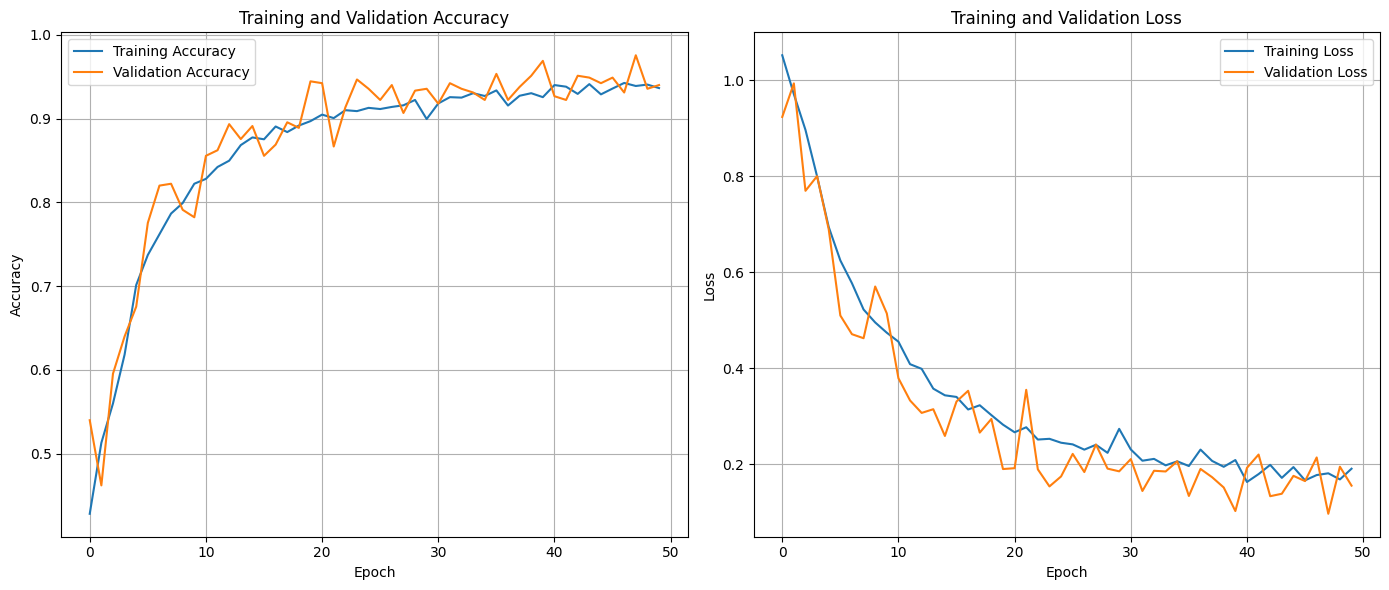


Model CNN siap untuk dievaluasi pada Test Set!


In [ ]:
print("--- Memulai Pembangunan dan Pelatihan Model CNN ---")

# --- 1. Dapatkan Jumlah Kelas ---
# Variabel train_generator sudah tersedia dari cell data loading sebelumnya
num_classes = train_generator.num_classes

print(f"\nJumlah kelas yang akan diklasifikasikan: {num_classes}")
print(f"Ukuran gambar input: {IMG_HEIGHT}x{IMG_WIDTH} piksel")

# --- 2. Bangun Arsitektur Model CNN Murni (dari awal) ---
# Menggunakan Sequential API untuk membangun model layer demi layer
model = Sequential([
    # Layer Konvolusi Pertama
    # 32 filter (feature maps), ukuran kernel 3x3, fungsi aktivasi ReLU.
    # input_shape harus sesuai dengan ukuran target_size (IMG_HEIGHT, IMG_WIDTH) dan 3 channel (RGB).
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)), # Mengurangi dimensi spasial (gambar menjadi lebih kecil)

    # Layer Konvolusi Kedua
    # Jumlah filter biasanya ditingkatkan seiring bertambahnya kedalaman (misal dari 32 ke 64).
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Layer Konvolusi Ketiga
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Layer Konvolusi Keempat (Opsional, bisa disesuaikan/dihapus)
    # Menambah layer dapat meningkatkan kapasitas model, tapi juga risiko overfitting.
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer: Mengubah output 3D dari lapisan konvolusi menjadi 1D
    # Ini diperlukan agar bisa diumpankan ke lapisan Dense (Fully Connected).
    layers.Flatten(),

    # Layer Fully Connected (Dense) Pertama
    # 512 neuron, fungsi aktivasi ReLU.
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), # Dropout: Mencegah overfitting dengan "mematikan" sebagian neuron secara acak (50%)

    # Layer Fully Connected (Dense) Kedua (Opsional, bisa disesuaikan/dihapus)
    # Menambah kapasitas model di bagian klasifikasi.
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), # Dropout lagi dengan probabilitas 30%

    # Output Layer
    # Jumlah neuron harus sama dengan num_classes (jumlah kategori penyakit daun).
    # Fungsi aktivasi 'softmax' menghasilkan probabilitas untuk setiap kelas, totalnya 1.
    layers.Dense(num_classes, activation='softmax')
])

# --- 3. Tampilkan Ringkasan Arsitektur Model ---
# Ini sangat membantu untuk memahami struktur model, jumlah parameter, dan bentuk output setiap layer.
print("\n--- Ringkasan Arsitektur Model CNN ---")
model.summary()

# --- 4. Kompilasi Model ---
# Konfigurasi proses pelatihan model.
model.compile(
    optimizer='adam', # Optimizer: Algoritma untuk mengoptimalkan bobot model (Adam adalah pilihan umum dan bagus)
    loss='categorical_crossentropy', # Fungsi Loss: Untuk klasifikasi multi-kelas dengan label one-hot encoded (sesuai class_mode='categorical')
    metrics=['accuracy'] # Metrik: Untuk memantau performa model (akurasi adalah metrik yang mudah dipahami)
)

print("\nModel CNN berhasil dibangun dan dikompilasi.")

# --- 5. Definisikan Callbacks (Sangat Direkomendasikan!) ---
# Callbacks adalah fungsi yang dipanggil selama pelatihan untuk tindakan tertentu.

# EarlyStopping: Untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan pada metrik validasi.
# monitor='val_loss': Memantau validasi loss.
# patience=10: Menunggu 10 epoch tanpa peningkatan sebelum menghentikan.
# restore_best_weights=True: Mengembalikan bobot model dari epoch terbaik yang dicapai.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1 # Menampilkan pesan saat callback dipicu
)

# ModelCheckpoint: Untuk menyimpan bobot model terbaik selama pelatihan.
# filepath: Lokasi dan nama file untuk menyimpan model.
# monitor='val_loss': Memantau validasi loss.
# save_best_only=True: Hanya menyimpan model jika performanya lebih baik dari sebelumnya.
model_checkpoint = ModelCheckpoint(
    filepath='best_coffee_leaf_cnn_model.h5', # Simpan sebagai file HDF5
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 6. Latih Model ---
# Memulai proses pelatihan model menggunakan data dari generator.
epochs = 50 # Jumlah maksimal epoch. EarlyStopping akan menghentikannya jika performa tidak lagi membaik.
print(f"\nMemulai pelatihan model selama maksimal {epochs} epoch...")

history = model.fit(
    train_generator, # Data training dari generator
    epochs=epochs,    # Jumlah epoch
    validation_data=validation_generator, # Data validasi dari generator untuk memantau performa
    callbacks=[early_stopping, model_checkpoint] # Menggunakan callbacks yang sudah didefinisikan
)

print("\nPelatihan model selesai!")
print(f"Model terbaik telah disimpan sebagai 'best_coffee_leaf_cnn_model.h5' di Google Drive-mu.")

# --- 7. Visualisasi Hasil Pelatihan ---
# Memplot kurva akurasi dan loss untuk training dan validation set.
print("\n--- Visualisasi Hasil Pelatihan ---")

plt.figure(figsize=(14, 6))

# Plot Kurva Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Kurva Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Mengatur layout agar tidak tumpang tindih
plt.show()

print("\nModel CNN siap untuk dievaluasi pada Test Set!")


--- Evaluasi Model CNN pada Test Set ---


15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 10s/step - accuracy: 0.9353 - loss: 0.1710

Test Loss     : 0.1415
Test Accuracy : 0.9511
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step

Classification Report (CNN):
              precision    recall  f1-score   support

 Daun_Bercak       0.97      0.92      0.94       150
  Daun_Karat       0.93      0.95      0.94       150
  Daun_Sehat       0.96      0.98      0.97       150

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



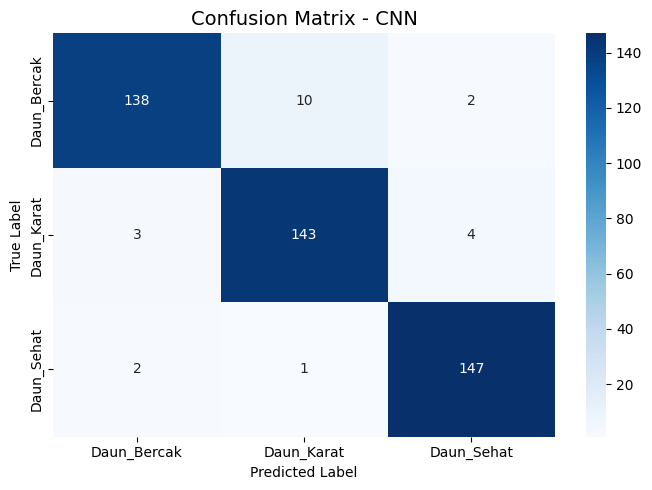


Evaluasi CNN pada test set selesai.


In [ ]:
# ============================================
# EVALUASI MODEL CNN PADA TEST SET
# ============================================

print("\n--- Evaluasi Model CNN pada Test Set ---")

# 1. (Opsional) Load model terbaik dari file
#    Kalau kamu ingin pakai model yang tersimpan di 'best_coffee_leaf_cnn_model.h5'
from tensorflow.keras.models import load_model

best_cnn_model = load_model('best_coffee_leaf_cnn_model.h5')

# 2. Pastikan test_generator di-reset (supaya urutan konsisten)
test_generator.reset()

# 3. Evaluasi akurasi & loss langsung dari Keras
test_loss, test_acc = best_cnn_model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

# 4. Prediksi untuk membuat classification report & confusion matrix
y_proba = best_cnn_model.predict(test_generator, verbose=1)
y_pred  = np.argmax(y_proba, axis=1)       # prediksi kelas
y_true  = test_generator.classes           # label asli (integer)

# Nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

print("\nClassification Report (CNN):")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CNN', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\nEvaluasi CNN pada test set selesai.")
